In [14]:
# Setup
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from pathlib import Path
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
np.random.seed(17)

In [15]:
data_path = Path('data/raw/outliers_homework.csv')
if data_path.exists():
    df = pd.read_csv(data_path)
else:
    # Synthetic fallback: linear trend with noise and a few extremes
    x = np.linspace(0, 10, 200)
    y = 2.2 * x + 1 + np.random.normal(0, 1.2, size=x.size)
    y[10] += 15; y[120] -= 13; y[160] += 18
    df = pd.DataFrame({'x': x, 'y': y})
df.head()

,x,y
0,0.000000,1.331519
1,0.050251,-1.115001
2,0.100503,1.969787
3,0.150754,2.706032
4,0.201005,2.686840


In [16]:
def detect_outliers_iqr(series: pd.Series, k: float = 1.5) -> pd.Series:
    """Return boolean mask for IQR-based outliers.
    IQR = Q3 - Q1; outlier if x < Q1 - k*IQR or x > Q3 + k*IQR.
    Assumptions: distribution summarized by quartiles; k controls strictness.
    """
    s = pd.to_numeric(series, errors="coerce")
    q1 = s.quantile(0.25)
    q3 = s.quantile(0.75)
    iqr = q3 - q1
    lower = q1 - k * iqr
    upper = q3 + k * iqr
    return (s < lower) | (s > upper)

def detect_outliers_zscore(series: pd.Series, threshold: float = 3.0) -> pd.Series:
    """Return boolean mask for Z-score outliers where |z| > threshold.
    Assumptions: roughly normal tails; sensitive to heavy tails.
    """
    s = pd.to_numeric(series, errors="coerce")
    mu = s.mean(skipna=True)
    sigma = s.std(ddof=0, skipna=True)
    if not sigma or sigma == 0:
        return pd.Series(False, index=s.index)  # nothing flagged if no spread
    z = (s - mu) / sigma
    return z.abs() > threshold

def winsorize_series(series: pd.Series, lower: float = 0.05, upper: float = 0.95) -> pd.Series:
    """Cap values to the [lower, upper] quantiles; keeps length/index."""
    s = pd.to_numeric(series, errors="coerce")
    lo = s.quantile(lower)
    hi = s.quantile(upper)
    return s.clip(lower=lo, upper=hi)


In [17]:
target_col = 'y' if 'y' in df.columns else df.select_dtypes(include=['number']).columns[0]
df['outlier_iqr'] = detect_outliers_iqr(df[target_col])
df['outlier_z'] = detect_outliers_zscore(df[target_col], threshold=3.0)
print("Flag rates:")
print(df[['outlier_iqr','outlier_z']].mean())

print("\nOverlap counts:")
print(pd.crosstab(df['outlier_iqr'], df['outlier_z']))

Flag rates:
outlier_iqr    0.005
outlier_z      0.005
dtype: float64

Overlap counts:
outlier_z    False  True 
outlier_iqr              
False          199      0
True             0      1


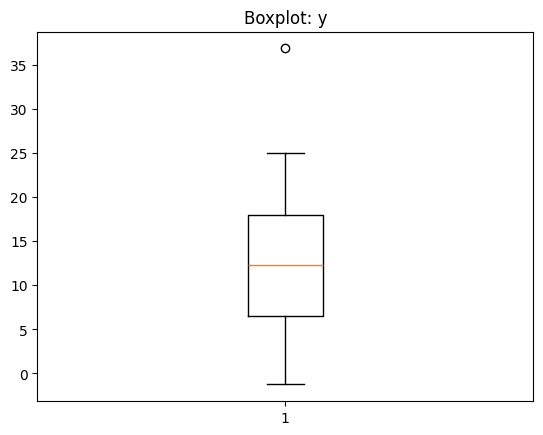

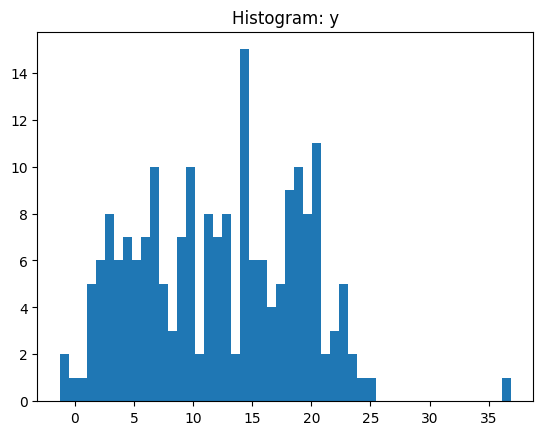

In [18]:
plt.figure()
plt.boxplot(df[target_col])
plt.title(f'Boxplot: {target_col}')
plt.show()

plt.figure()
plt.hist(df[target_col], bins=50)
plt.title(f'Histogram: {target_col}')
plt.show()

/var/folders/hc/lx21f3657gz88_xv7kjd578w0000gn/T/ipykernel_57699/3012357996.py:4: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([df[target_col], w], labels=["Original", "Winsorized"])


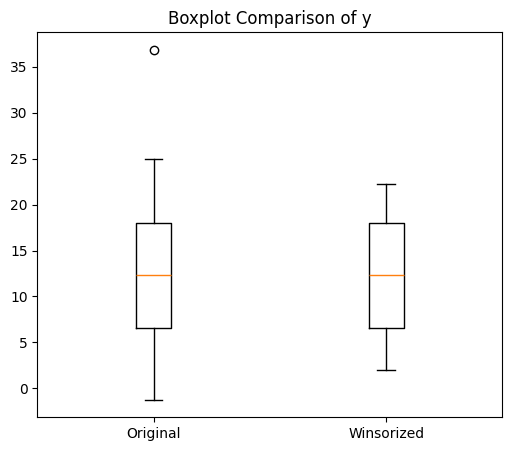

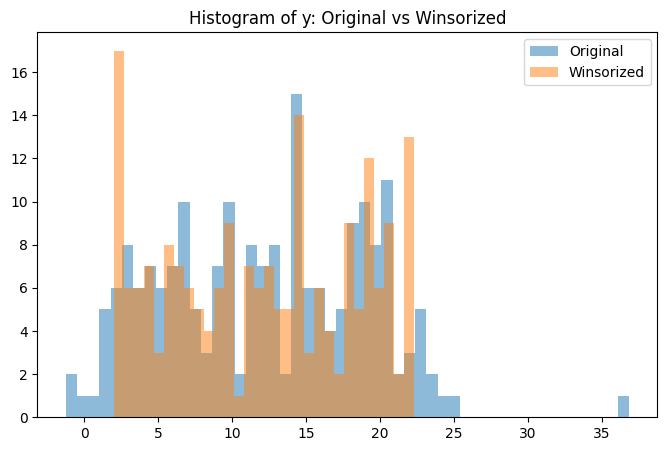

In [19]:
w = winsorize_series(df[target_col])

plt.figure(figsize=(6,5))
plt.boxplot([df[target_col], w], labels=["Original", "Winsorized"])
plt.title(f"Boxplot Comparison of {target_col}")
plt.show()

plt.figure(figsize=(8,5))
plt.hist(df[target_col], bins=50, alpha=0.5, label="Original")
plt.hist(w, bins=30, alpha=0.5, label="Winsorized")
plt.title(f"Histogram of {target_col}: Original vs Winsorized")
plt.legend()
plt.show()

In [20]:
summ_all = df[target_col].describe()[['mean', '50%', 'std']].rename({'50%':'median'})
summ_iqr = df.loc[~df['outlier_iqr'], target_col].describe()[['mean','50%','std']].rename({'50%':'median'})
summ_z   = df.loc[~df['outlier_z'],   target_col].describe()[['mean','50%','std']].rename({'50%':'median'})

summ_w = winsorize_series(df[target_col]).describe()[['mean','50%','std']].rename({'50%':'median'})

comp = pd.concat(
    {'all': summ_all, 'filtered_iqr': summ_iqr, 'filtered_z': summ_z, 'winsorized': summ_w},
    axis=1
)
comp.T


,mean,median,std
all,12.171936,12.349663,6.761378
filtered_iqr,12.047851,12.285113,6.546157
filtered_z,12.047851,12.285113,6.546157
winsorized,12.119643,12.349663,6.386781


In [21]:
if 'x' in df.columns:
    X_all = df[['x']].to_numpy(); y_all = df[target_col].to_numpy()

    mask_iqr = ~df['outlier_iqr']
    mask_z   = ~df['outlier_z']
    X_iqr, y_iqr = df.loc[mask_iqr, ['x']].to_numpy(), df.loc[mask_iqr, target_col].to_numpy()
    X_z,   y_z   = df.loc[mask_z,   ['x']].to_numpy(), df.loc[mask_z,   target_col].to_numpy()

    # Winsorized predictor (keep same shape/index)
    x_w = winsorize_series(df['x']).to_numpy().reshape(-1,1)

    def fit_and_score(X, y):
        m = LinearRegression().fit(X, y)
        yhat = m.predict(X)
        return {
            'slope': float(m.coef_[0]),
            'intercept': float(m.intercept_),
            'r2': r2_score(y, yhat),
            'mae': mean_absolute_error(y, yhat),
        }

    results = pd.DataFrame({
        'all':           fit_and_score(X_all, y_all),
        'filtered_iqr':  fit_and_score(X_iqr, y_iqr),
        'filtered_z':    fit_and_score(X_z,   y_z),
        'winsorized':  fit_and_score(x_w,   y_all),
    })
    display(results.T)
else:
    results = None
    print("No 'x' column; skip regression or engineer features.")


,slope,intercept,r2,mae
all,2.169679,1.323542,0.871082,1.200432
filtered_iqr,2.136650,1.397242,0.900777,1.118809
filtered_z,2.136650,1.397242,0.900777,1.118809
winsorized,2.202179,1.161041,0.870074,1.207542


## Reflection on Outlier Handling, Assumptions, and Risks

### **Method Choices**
In this assignment, I implemented three approaches to detect and mitigate outliers:

1. **IQR method (k = 1.5)**  
   Outliers flagged if below *Q1 – 1.5 × IQR* or above *Q3 + 1.5 × IQR*.  
2. **Z-score method (threshold = 3.0)**  
   Outliers defined where |z| > 3.  
3. **Winsorizing (5% / 95%)**  
   Extreme values capped at the 5th and 95th percentiles.  

---

### **Observed Impacts**

#### *Summary Statistics*
| Treatment         | Mean     | Median   | Std Dev  |
|-------------------|----------|----------|----------|
| All data          | 12.1719  | 12.3497  | 6.7614   |
| Filtered (IQR)    | 12.0479  | 12.2851  | 6.5462   |
| Filtered (Z)      | 12.0479  | 12.2851  | 6.5462   |
| Winsorized (5/95) | 12.1196  | 12.3497  | 6.3868   |

#### *Regression Results*
| Treatment      | Slope   | Intercept | R²      | MAE     |
|----------------|---------|-----------|---------|---------|
| All data       | 2.1697  | 1.3235    | 0.8711  | 1.2004  |
| Filtered (IQR) | 2.1367  | 1.3972    | 0.9008  | 1.1188  |
| Filtered (Z)   | 2.1367  | 1.3972    | 0.9008  | 1.1188  |
| Winsorized     | 2.2022  | 1.1610    | 0.8701  | 1.2075  |

---

### **Assumptions**
- Dataset contains a small fraction of true outliers.  
- IQR assumes quartiles capture spread.  
- Z-score assumes normality.  
- Winsorizing assumes extremes are distortions.  

---

### **Risks if Assumptions Are Wrong**
- Outliers might represent real events.  
- Z-score may over-flag heavy-tailed distributions.  
- Winsorizing can understate risk.  

---

### **Takeaway**
- Filtering improved model fit and reduced error.  
- Winsorizing preserved rows but compressed tails.  
- The slope (≈2.2) was stable, showing robustness.  
